In [32]:
import cftime
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from typing import Optional

%matplotlib widget

In [40]:
# Load one SWIFT file to investigate the Spectra
fname = '../data/swift-data/SASSIE_Fall_2022_SWIFT12_play1.nc'
swift_data = nc.Dataset(fname)

# Load Data
frequency = swift_data['frequency'][:]
wave_energy = swift_data['wave_energy'][:]
wave_height = swift_data['surface_wave_height'][:]
time = cftime.num2pydate(swift_data['time'][:], units=swift_data['time'].units)
a1 = swift_data['spectral_directional_moment_east'][:]
b1 = swift_data['spectral_directional_moment_north'][:]
mean_wave_dir = swift_data['surface_wave_direction'][:]

swift_data.close()

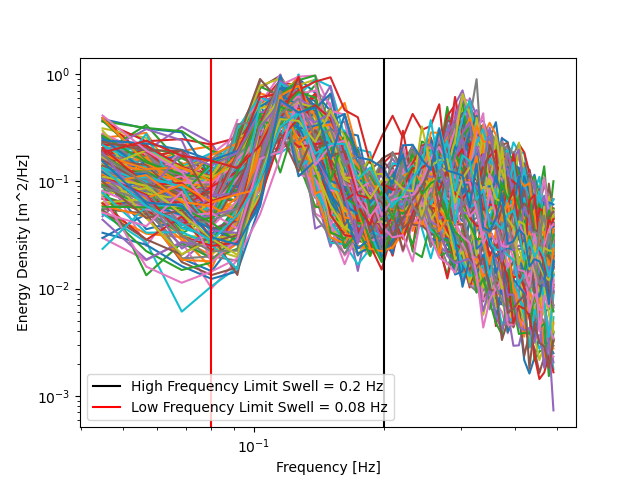

In [17]:
# Plot all the Spectra from this example
fig, ax = plt.subplots()
ax.loglog(frequency, wave_energy)
ax.axvline(0.2, color='k', label='High Frequency Limit Swell = 0.2 Hz')
ax.axvline(0.08, color='r', label='Low Frequency Limit Swell = 0.08 Hz')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Energy Density [m^2/Hz]')
ax.legend()

In [22]:
f_low = 0.08
f_high = 0.2
inds = np.where((frequency >= f_low) & (frequency <= f_high))[0]
n = 0
Hs = 4 * np.sqrt(np.trapz(wave_energy[inds, n], frequency[inds]))
print(Hs)

0.5240124147990818


In [29]:
wave_energy.shape

(42, 161)

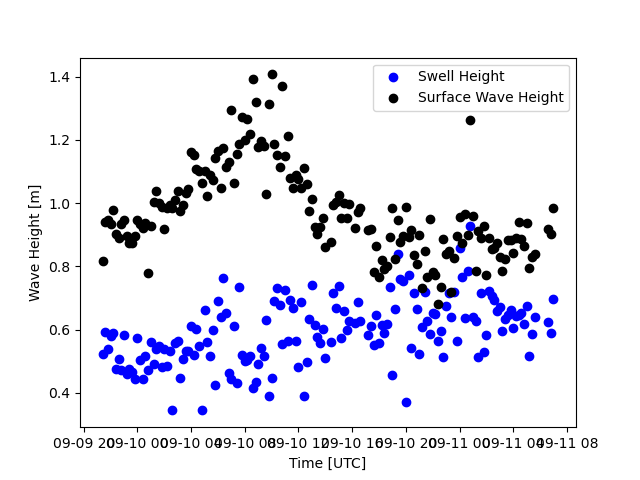

In [31]:
# Integrate the Spectrum between these frequency limits to get a new significant wave height
def compute_sigwave_height_frequency_band(spectra, frequency, f_low, f_high):
    # Find indices between the frequency limits
    Hs = np.empty(spectra.shape[1])
    for n in range(spectra.shape[1]):
        inds = np.where((frequency >= f_low) & (frequency <= f_high))[0] 
        Hs[n] = 4 * np.sqrt(np.trapz(spectra[inds, n], frequency[inds]))
    return Hs

f_low = 0.08
f_high = 0.2
swell_height = compute_sigwave_height_frequency_band(wave_energy, frequency, f_low, f_high)

fig, ax = plt.subplots()
ax.scatter(time, swell_height, color='b', label='Swell Height')
ax.scatter(time, wave_height, color='k', label='Surface Wave Height')
ax.set_xlabel('Time [UTC]')
ax.set_ylabel('Wave Height [m]')
ax.legend()

150.14946452148905
52.389678955078125


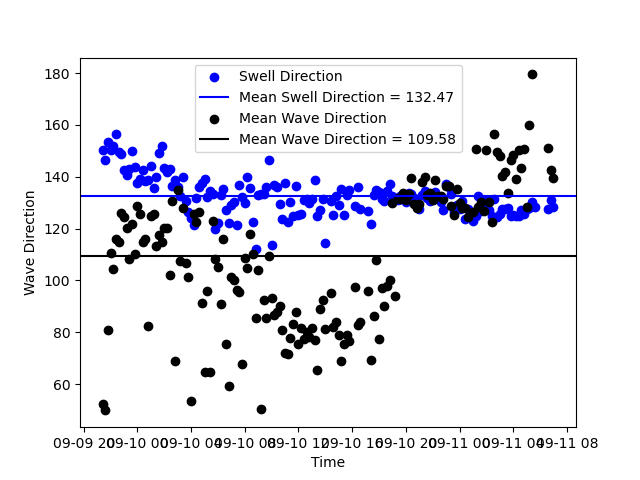

In [ ]:
# Investigate 2d Spectra and compute swell direction from the spectral moments
def energy_weighted_direction(
    energy_density: np.ndarray,
    frequency: np.ndarray,
    a1: np.ndarray,
    b1: np.ndarray,
    min_frequency: Optional[float] = None,
    max_frequency: Optional[float] = None,
):
    a1_weighted = energy_weighted_mean(a1,
                                        energy_density,
                                        frequency,
                                        min_frequency=min_frequency,
                                        max_frequency=max_frequency)
    b1_weighted = energy_weighted_mean(b1,
                                        energy_density,
                                        frequency,
                                        min_frequency=min_frequency,
                                        max_frequency=max_frequency)
    mean_direction = (direction(a1_weighted, b1_weighted))

    return mean_direction



def energy_weighted_mean(
    X: np.ndarray,
    energy_density: np.ndarray,
    frequency: np.ndarray,
    min_frequency: Optional[float] = None,
    max_frequency: Optional[float] = None,
) -> np.ndarray:
    """TODO:"""
    if min_frequency is None:
        min_frequency = frequency.min()

    if max_frequency is None:
        max_frequency = frequency.max()

    # Mask frequencies outside of the specified range.  Must be 0 and not NaN.
    frequency_mask = np.logical_and(frequency >= min_frequency,
                                    frequency <= max_frequency)
    frequency = frequency[frequency_mask]
    energy_density = energy_density[..., frequency_mask]
    X = X[..., frequency_mask]

    # Compute energy-weighted mean.
    m0 = spectral_moment(energy_density, frequency, n=0)
    weighted_integral = np.trapz(y=energy_density * X, x=frequency)
    return weighted_integral / m0


def spectral_moment(
    energy_density: np.ndarray,
    frequency: np.ndarray,
    n: float = 0,
    min_frequency: Optional[float] = None,
    max_frequency: Optional[float] = None,
) -> np.ndarray:
    """
    Function to compute 'nth' spectral moment

    Note:
        This function requires that the frequency dimension is along the last
        axis of `energy_density`.  If energy is empty or null, NaN is returned.

    Args:
        energy_density (np.ndarray): 1-D energy density frequency spectrum with
            shape (f,) or (..., f).
        frequency (np.ndarray): 1-D frequencies with shape (f,).
        n (float): Moment order (e.g., `n=1` is returns the first moment).
        min_frequency (float, optional): lower frequency bound.
        max_frequency (float, optional): upper frequency bound.

    Output:
        Union[float, np.ndarray]: nth spectral moment

    Example:

    Compute 4th spectral moment:
        m4 = spectral_moment(energy, frequency, n=4)
    """
    # Assign default min and max frequencies.
    if min_frequency is None:
        min_frequency = frequency.min()

    if max_frequency is None:
        max_frequency = frequency.max()

    # Mask frequencies outside of the specified range. Must be 0 and not
    # NaN to avoid null output from trapz.
    frequency_mask = np.logical_and(frequency >= min_frequency,
                                    frequency <= max_frequency)
    frequency = frequency[frequency_mask]
    energy_density = energy_density[..., frequency_mask]
    # frequency = np.where(frequency_mask, frequency, 0)
    # energy_density = np.where(frequency_mask, energy_density, 0)

    # Compute nth spectral moment.
    fn = frequency ** n
    mn = np.trapz(energy_density * fn, x=frequency, axis=-1)
    return mn


def direction(a1: np.ndarray, b1: np.ndarray) -> np.ndarray:
    """ Return the frequency-dependent direction from the directional moments.

    Calculate the direction at each frequency from the first two Fourier
    coefficients of the directional spectrum (see Sofar and Kuik et al.).

    References:
        Sofar (n.d.) Spotter Technical Reference Manual

        A J Kuik, G P Van Vledder, and L H Holthuijsen (1988) "A method for the
        routine analysis of pitch-and-roll buoy wave data" JPO, 18(7), 1020-
        1034, 1988.

    Args:
        a1 (np.ndarray): Normalized spectral directional moment (+E).
        b1 (np.ndarray): Normalized spectral directional moment (+N).

    Returns:
        np.ndarray: Direction at each spectral frequency in the metereological
            convention (degrees clockwise from North).
    """
    return (270 - np.rad2deg(np.arctan2(b1, a1))) % 360
    
# Test these functions to find the swell direction
# Note the -180 to switch from toward to from direction to compare
n = 0
swell_direction = energy_weighted_direction(wave_energy[:,n], frequency, a1[:,n], b1[:,n], f_low, f_high) - 180
print(swell_direction)
print(mean_wave_dir[n])

swell_direction = np.empty(time.size)
for n in range(time.size):
    swell_direction[n] = energy_weighted_direction(wave_energy[:,n], frequency, a1[:,n], b1[:,n], f_low, f_high) - 180

fig, ax = plt.subplots()
ax.scatter(time, swell_direction, color='b', label='Swell Direction')
ax.axhline(np.mean(swell_direction), color='b', label=f'Mean Swell Direction = {np.round(np.mean(swell_direction), 2)}')
ax.scatter(time, mean_wave_dir, color='k', label='Mean Wave Direction')
ax.axhline(np.mean(mean_wave_dir), color='k', label=f'Mean Wave Direction = {np.round(np.mean(mean_wave_dir), 2)}')
ax.set_xlabel('Time')
ax.set_ylabel('Wave Direction')
ax.legend()
